In [1]:
import tensorflow as tf

In [2]:
import matplotlib.pylab as plt

import tensorflow_hub as hub
import tensorflow_datasets as tfds
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

import numpy as np
import PIL.Image as Image

In [3]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [4]:
CLASSIFIER_URL ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2"
IMG_RES = 224

model = Sequential([
        hub.KerasLayer(CLASSIFIER_URL, input_shape=(IMG_RES, IMG_RES, 3))
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1001)              3540265   
Total params: 3,540,265
Trainable params: 0
Non-trainable params: 3,540,265
_________________________________________________________________


In [5]:
grace_hopper = tf.keras.utils.get_file('image.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize((IMG_RES, IMG_RES))

65536/61306 [================================] - 0s 0us/step


In [6]:
grace_hopper = np.array(grace_hopper)/255.0
grace_hopper.shape

(224, 224, 3)

In [7]:
result = model.predict(grace_hopper[np.newaxis, ...])
result.shape

(1, 1001)

In [8]:
predicted_class = np.argmax(result[0], axis=-1)
predicted_class

653

16384/10484 [==============================================] - 0s 0us/step


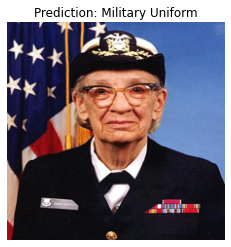

In [9]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title('Prediction: ' + predicted_class_name.title())

In [10]:
(train_examples, validation_examples), info = tfds.load(
    'cats_vs_dogs',
    with_info=True,
    as_supervised=True,
    split=['train[:80%]', 'train[80%:]'],
)

num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes

print("No. examples: ", num_examples)
print("No. classes: ", num_classes)

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Shuffling and writing examples to /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incomplete8FDPGC/cats_vs_dogs-train.tfrecord



Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.
No. examples:  23262
No. classes:  2


In [11]:
for count, example_image in enumerate(train_examples.take(3)):
  print("Image {} shape: {}".format(count+1, example_image[0].shape))

Image 1 shape: (262, 350, 3)
Image 2 shape: (409, 336, 3)
Image 3 shape: (493, 500, 3)


In [12]:
def format_image(image, label):
  image= tf.image.resize(image, (IMG_RES,IMG_RES))/255.0
  return image, label

BATCH_SIZE = 32

train_batches = train_examples.shuffle(num_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_examples.map(format_image).batch(BATCH_SIZE).prefetch(1)

In [13]:
image_batch, label_batch = next(iter(train_batches.take(1)))
image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

result_batch = model.predict(image_batch)

predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
predicted_class_names

array(['tabby', 'Labrador retriever', 'Chihuahua', 'dalmatian',
       'cocker spaniel', 'Tibetan terrier', 'pug', 'Siamese cat',
       'Labrador retriever', 'Angora', 'Persian cat', 'English foxhound',
       'Siamese cat', 'boxer', 'tabby', 'Egyptian cat', 'lynx',
       'Leonberg', 'Boston bull', 'dalmatian', 'Egyptian cat', 'muzzle',
       'Egyptian cat', 'tabby', 'tabby', 'Egyptian cat', 'tennis ball',
       'Siamese cat', 'bloodhound', 'affenpinscher', 'schipperke',
       'tiger cat'], dtype='<U30')

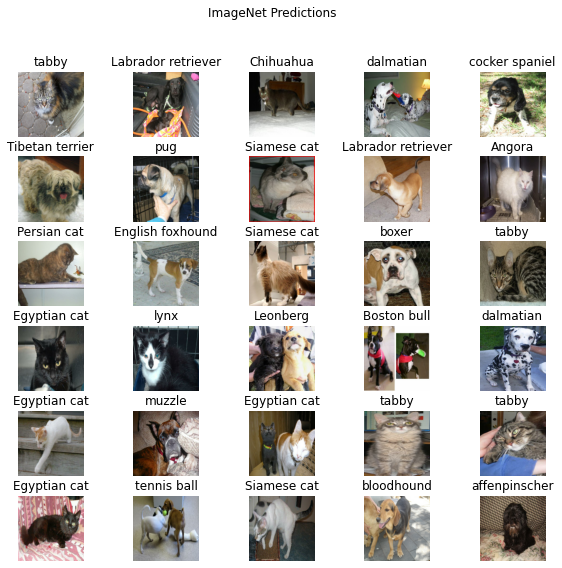

In [14]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace=0.3)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
  _= plt.suptitle('ImageNet Predictions')

In [15]:
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2"
feature_extractor = hub.KerasLayer(URL,
                                   input_shape=(IMG_RES,IMG_RES,3))

In [16]:
feature_batch = feature_extractor(image_batch)
feature_batch.shape

TensorShape([32, 1280])

In [17]:
feature_extractor.trainable = False

In [18]:
model = Sequential([
        feature_extractor,
        layers.Dense(2)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [19]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

epochs = 6
history = model.fit(train_batches,
                    epochs=epochs,
                    validation_data=validation_batches)

Epoch 1/6
582/582 [==============================] - 599s 1s/step - loss: 0.0513 - accuracy: 0.9831 - val_loss: 0.0397 - val_accuracy: 0.9867
Epoch 2/6
582/582 [==============================] - 604s 1s/step - loss: 0.0321 - accuracy: 0.9895 - val_loss: 0.0343 - val_accuracy: 0.9888
Epoch 3/6
582/582 [==============================] - 603s 1s/step - loss: 0.0244 - accuracy: 0.9915 - val_loss: 0.0300 - val_accuracy: 0.9908
Epoch 4/6
582/582 [==============================] - 602s 1s/step - loss: 0.0221 - accuracy: 0.9926 - val_loss: 0.0311 - val_accuracy: 0.9912
Epoch 5/6
582/582 [==============================] - 602s 1s/step - loss: 0.0189 - accuracy: 0.9934 - val_loss: 0.0330 - val_accuracy: 0.9905
Epoch 6/6
582/582 [==============================] - 603s 1s/step - loss: 0.0180 - accuracy: 0.9941 - val_loss: 0.0326 - val_accuracy: 0.9895


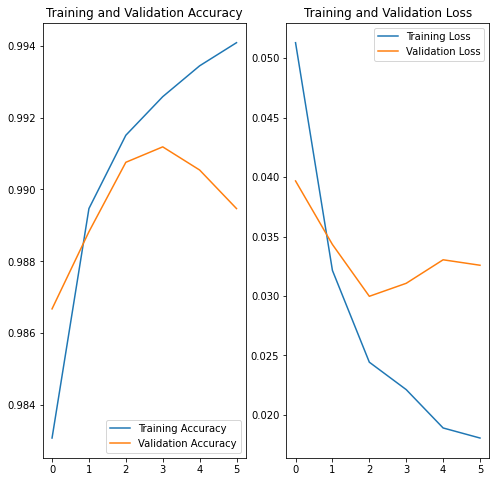

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [21]:
class_names = np.array(info.features['label'].names)
class_names

array(['cat', 'dog'], dtype='<U3')

In [22]:
predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()
predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]
predicted_class_names

array(['cat', 'dog', 'cat', 'dog', 'dog', 'dog', 'dog', 'cat', 'dog',
       'cat', 'cat', 'dog', 'cat', 'dog', 'cat', 'cat', 'cat', 'dog',
       'dog', 'dog', 'cat', 'dog', 'cat', 'cat', 'cat', 'cat', 'dog',
       'cat', 'dog', 'dog', 'cat', 'cat'], dtype='<U3')

In [23]:
print("Labels: ", label_batch)
print("Predicted labels: ", predicted_ids)

Labels:  [0 1 0 1 1 1 1 0 1 0 0 1 0 1 0 0 0 1 1 1 0 1 0 0 0 0 1 0 1 1 0 0]
Predicted labels:  [0 1 0 1 1 1 1 0 1 0 0 1 0 1 0 0 0 1 1 1 0 1 0 0 0 0 1 0 1 1 0 0]


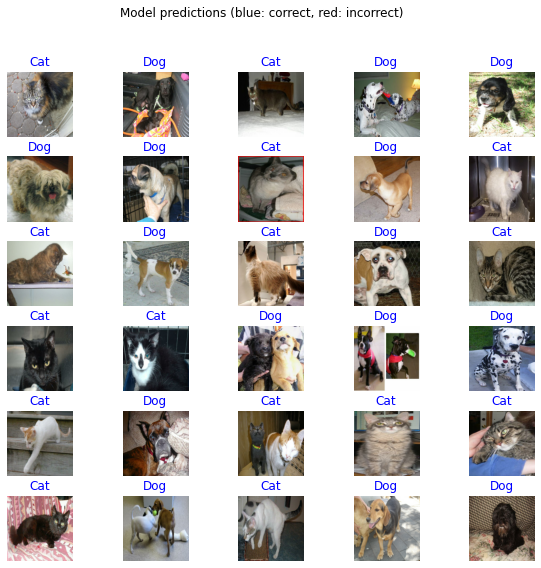

In [24]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  color = "blue" if predicted_ids[n] == label_batch[n] else "red"
  plt.title(predicted_class_names[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")